In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from diffusion_policy_3d.env.adroit.adroit import AdroitEnv
import torch
from PIL import Image
import torchvision.transforms as T

def load_and_process_images(image_dir="adroit_camera_test", target_size=(168, 168)):
    """
    Load images from directory, resize them to target_size, and normalize to [0,1]
    
    Args:
        image_dir (str): Directory containing the images
        target_size (tuple): Target size for resizing (height, width)
    
    Returns:
        dict: Dictionary mapping filenames to processed torch tensors
    """
    # Define transforms
    transforms = T.Compose([
        T.Resize(target_size),
        T.ToTensor(),  # This also normalizes to [0,1]
    ])
    
    # Initialize dictionary to store processed images
    processed_images = {}
    
    # Process each image in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Load image
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).convert('RGB')            
            # Apply transforms
            img_tensor = transforms(img)
            
            # Store in dictionary
            processed_images[filename] = img_tensor
            
            print(f"Processed {filename}: shape {img_tensor.shape}")
    
    return processed_images


processed_images = load_and_process_images()
processed_images.keys()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Processed high_right.png: shape torch.Size([3, 168, 168])
Processed high_left.png: shape torch.Size([3, 168, 168])
Processed high_front_right.png: shape torch.Size([3, 168, 168])
Processed fixed.png: shape torch.Size([3, 168, 168])
Processed top.png: shape torch.Size([3, 168, 168])
Processed high_back_right.png: shape torch.Size([3, 168, 168])
Processed high_back_left.png: shape torch.Size([3, 168, 168])
Processed high_front_left.png: shape torch.Size([3, 168, 168])
Processed high_back.png: shape torch.Size([3, 168, 168])
Processed vil_camera.png: shape torch.Size([3, 168, 168])
Processed high_front.png: shape torch.Size([3, 168, 168])


/home/san/dp3/3D-Diffusion-Policy/third_party/gym-0.21.0/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


dict_keys(['high_right.png', 'high_left.png', 'high_front_right.png', 'fixed.png', 'top.png', 'high_back_right.png', 'high_back_left.png', 'high_front_left.png', 'high_back.png', 'vil_camera.png', 'high_front.png'])

In [6]:
# device = 'cuda'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_batch = torch.stack([processed_images[k] for k in processed_images.keys()])
image_batch = image_batch.to(device)
print(image_batch.shape)

torch.Size([11, 3, 168, 168])


In [7]:
image_batch = image_batch.unsqueeze(0)
image_batch.shape

torch.Size([1, 11, 3, 168, 168])

In [8]:
import sys, os
sys.path.append('/home/san/dp3/vggt')
from vggt.models.vggt import VGGT
import time

import torch 

def load_vggt(image_batch, device="cuda", attention_layer=23):
    v = VGGT()
    url = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
    v.load_state_dict(torch.hub.load_state_dict_from_url(url))
    v.to(device)
    v.eval()
    vggt_dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
    print(image_batch.shape)
    start_time = time.time()
    with torch.no_grad():
        with torch.amp.autocast('cuda', dtype=vggt_dtype):
            # Predict attributes including cameras, depth maps, and point maps.
            predictions = v(image_batch)
            tokens, pos_idx = v.aggregator(image_batch)
            tokens = tokens[attention_layer][:, :, pos_idx:, :]

    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")

    return v, vggt_dtype, predictions, tokens


_, _, vggt_predictions, vggt_tokens = load_vggt(image_batch)
print(vggt_tokens.shape, vggt_predictions['images'].shape)

torch.Size([1, 11, 3, 168, 168])
Time taken: 0.29670214653015137 seconds
torch.Size([1, 11, 144, 2048]) torch.Size([1, 11, 3, 168, 168])


/home/san/dp3/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [ ]:
# Number of views affects the time taken!
# _, _, vggt_predictions = load_vggt(image_batch[:, :3, ...])

torch.Size([1, 3, 3, 168, 168])
Time taken: 0.0389556884765625 seconds


In [31]:
vggt_predictions['depth'].shape, vggt_predictions['images'].shape

(torch.Size([1, 3, 168, 168, 1]), torch.Size([1, 3, 3, 168, 168]))

/home/san/miniconda3/envs/dp3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(144, 2048) (5, 2048)

Clustering quality metrics:
Silhouette score: 0.157 (ranges from -1 to 1, higher is better)
Calinski-Harabasz score: 31.657 (higher is better)

Cluster separation analysis:
Average within-cluster distance: 26.483
Average between-cluster distance: 46.034
Ratio (between/within): 1.738


/home/san/miniconda3/envs/dp3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/san/miniconda3/envs/dp3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/san/miniconda3/envs/dp3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/san/miniconda3/envs/dp3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

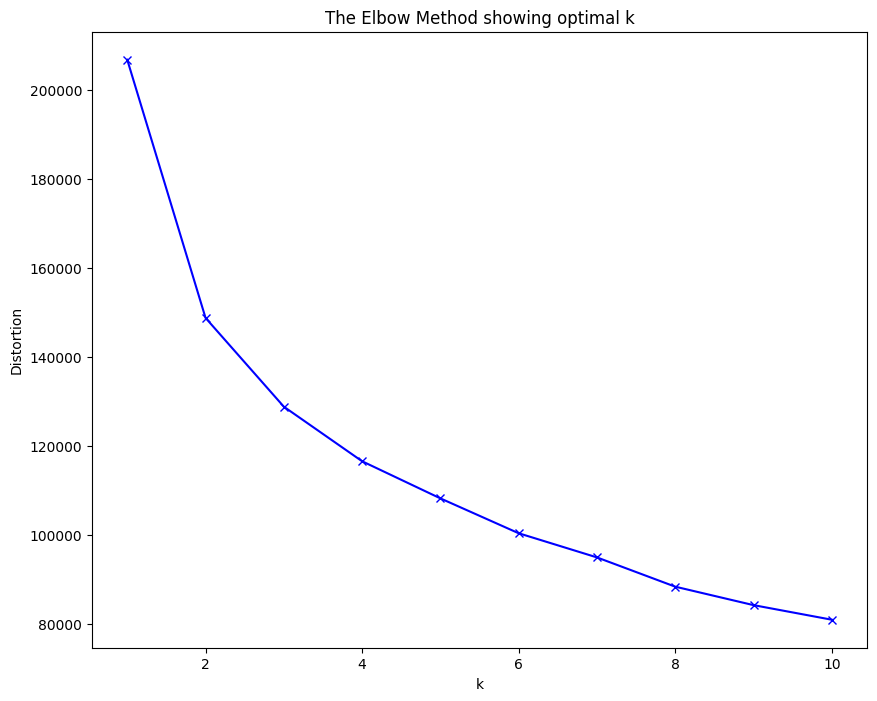

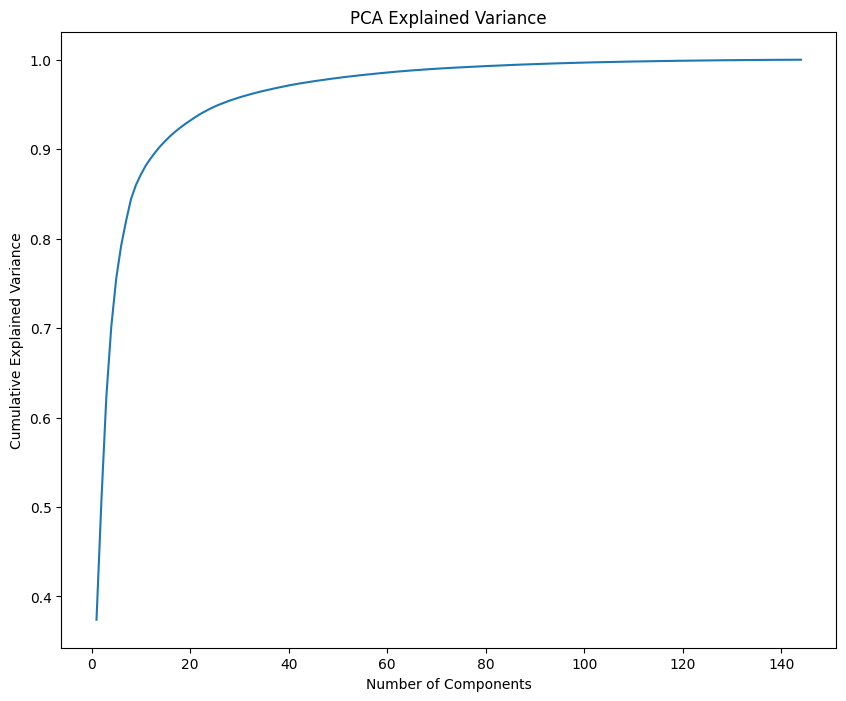


Top 10 PCA components explain 87.16% of variance


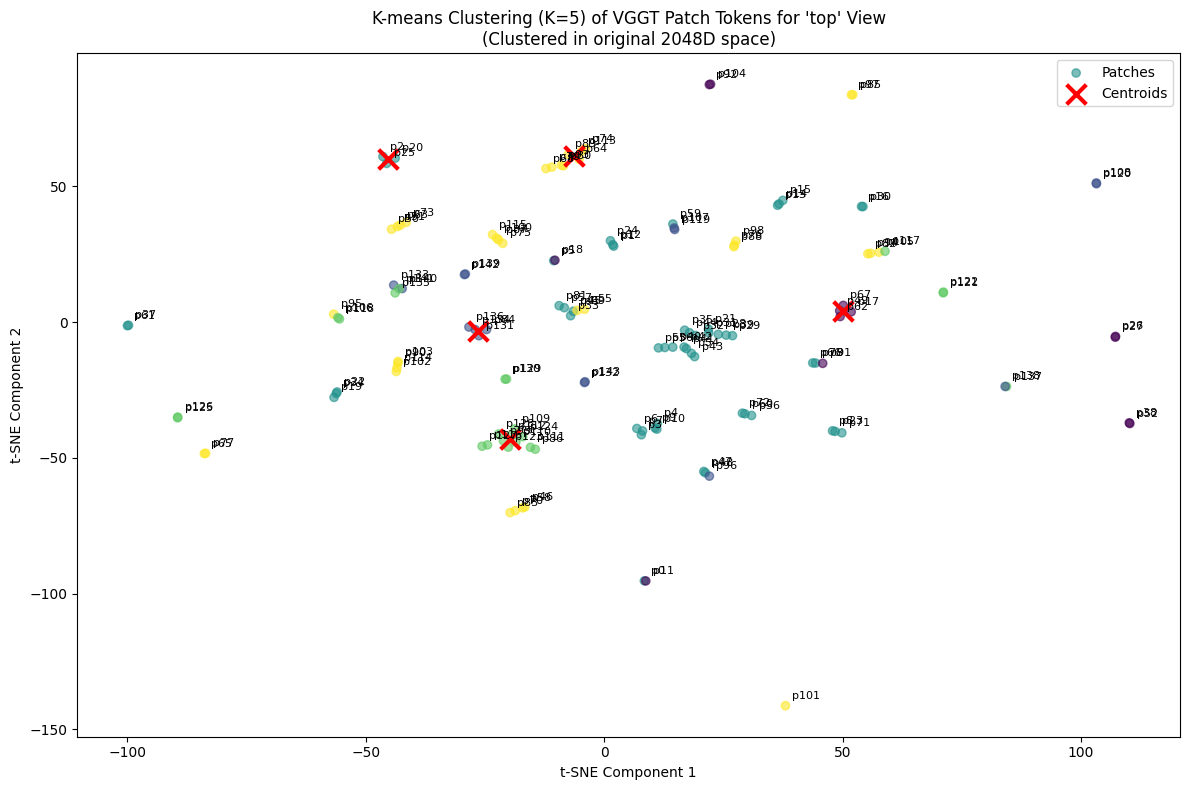

Cluster 0 size: 13
Cluster 1 size: 16
Cluster 2 size: 54
Cluster 3 size: 23
Cluster 4 size: 38

Cluster 0 patches: [ 11  17  18  26  27  38  49  52  62  67  91  92 104]

Cluster 1 patches: [ 84  96 107 108 119 120 131 132 133 134 136 138 139 140 142 143]

Cluster 2 patches: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 19 20 21 22 23 24 25 28
 29 30 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 48 53 54 56 57 59 60
 61 66 71 72 78 81]

Cluster 3 patches: [ 86  99 106 109 110 111 112 116 117 118 121 122 123 124 125 126 127 128
 129 130 135 137 141]

Cluster 4 patches: [ 46  50  51  55  58  63  64  65  68  69  70  73  74  75  76  77  79  80
  82  83  85  87  88  89  90  93  94  95  97  98 100 101 102 103 105 113
 114 115]

Cluster 0 average distance to centroid: 26.70

Cluster 1 average distance to centroid: 27.33

Cluster 2 average distance to centroid: 28.33

Cluster 3 average distance to centroid: 24.46

Cluster 4 average distance to centroid: 25.59


In [15]:
# Get the 'top' view index
view_names = ['high_right', 'high_left', 'high_front_right', 'fixed', 'top', 
              'high_back_right', 'high_back_left', 'high_front_left', 'high_back',
              'vil_camera', 'high_front']
top_view_idx = view_names.index('top')

# Extract features for the 'top' view
# Shape: (batch=1, patches=144, dim=2048)
top_view_features = vggt_tokens[0, top_view_idx]
top_view_features = top_view_features.cpu().detach().numpy()

# Perform K-means clustering directly on the high-dimensional features
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(top_view_features)
centroids = kmeans.cluster_centers_

print(top_view_features.shape, centroids.shape)
# Let's try a few different approaches to analyze the clustering

# 1. Calculate silhouette score to measure clustering quality
from sklearn.metrics import silhouette_score, calinski_harabasz_score
silhouette_avg = silhouette_score(top_view_features, cluster_labels)
calinski_score = calinski_harabasz_score(top_view_features, cluster_labels)

print(f"\nClustering quality metrics:")
print(f"Silhouette score: {silhouette_avg:.3f} (ranges from -1 to 1, higher is better)")
print(f"Calinski-Harabasz score: {calinski_score:.3f} (higher is better)")

# 2. Analyze within-cluster and between-cluster distances
within_dists = []
for i in range(n_clusters):
    cluster_points = top_view_features[cluster_labels == i]
    centroid = centroids[i]
    within_dists.append(np.mean(np.linalg.norm(cluster_points - centroid, axis=1)))

between_dists = []
for i in range(n_clusters):
    for j in range(i+1, n_clusters):
        dist = np.linalg.norm(centroids[i] - centroids[j])
        between_dists.append(dist)

print(f"\nCluster separation analysis:")
print(f"Average within-cluster distance: {np.mean(within_dists):.3f}")
print(f"Average between-cluster distance: {np.mean(between_dists):.3f}")
print(f"Ratio (between/within): {np.mean(between_dists)/np.mean(within_dists):.3f}")

# 3. Try elbow method to find optimal K
from sklearn.cluster import KMeans
distortions = []
K = range(1, 11)
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(top_view_features)
    distortions.append(kmeans_model.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimal k')
plt.show()

# 4. PCA to see variance explained by top components
from sklearn.decomposition import PCA
pca = PCA()
pca_result = pca.fit(top_view_features)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

print("\nTop 10 PCA components explain {:.2f}% of variance".format(
    100 * np.sum(pca.explained_variance_ratio_[:10])))


# Now reduce dimensionality with t-SNE just for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
# Stack features and centroids together for t-SNE
combined_data = np.vstack([top_view_features, centroids])
# Create labels array to track which points are features vs centroids 
combined_labels = np.concatenate([np.zeros(len(top_view_features)), np.ones(len(centroids))])

# Apply t-SNE on combined data
combined_tsne = tsne.fit_transform(combined_data)

# Split back into features and centroids
features_tsne = combined_tsne[:len(top_view_features)]
centroids_tsne = combined_tsne[len(top_view_features):]


tsne_results = features_tsne
# # Also transform centroids to same space for visualization
# centroids_tsne = tsne.fit_transform(centroids)

# Create scatter plot with clusters
plt.figure(figsize=(12, 8))

# Plot points colored by cluster
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                     c=cluster_labels, cmap='viridis', 
                     alpha=0.6, label='Patches')

# Plot centroids
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], 
           c='red', marker='x', s=200, linewidths=3, 
           label='Centroids')

# Add patch indices for reference
for i in range(len(tsne_results)):
    plt.annotate(f'p{i}', (tsne_results[i, 0], tsne_results[i, 1]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.title("K-means Clustering (K=5) of VGGT Patch Tokens for 'top' View\n(Clustered in original 2048D space)")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.show()

# Print cluster sizes
for i in range(n_clusters):
    print(f"Cluster {i} size: {sum(cluster_labels == i)}")

# Print which patches belong to each cluster
for i in range(n_clusters):
    patch_indices = np.where(cluster_labels == i)[0]
    print(f"\nCluster {i} patches: {patch_indices}")

# Calculate and print average distance to centroid for each cluster
from sklearn.metrics import pairwise_distances
for i in range(n_clusters):
    cluster_points = top_view_features[cluster_labels == i]
    centroid = centroids[i]
    distances = pairwise_distances(cluster_points, [centroid])
    avg_distance = np.mean(distances)
    print(f"\nCluster {i} average distance to centroid: {avg_distance:.2f}")




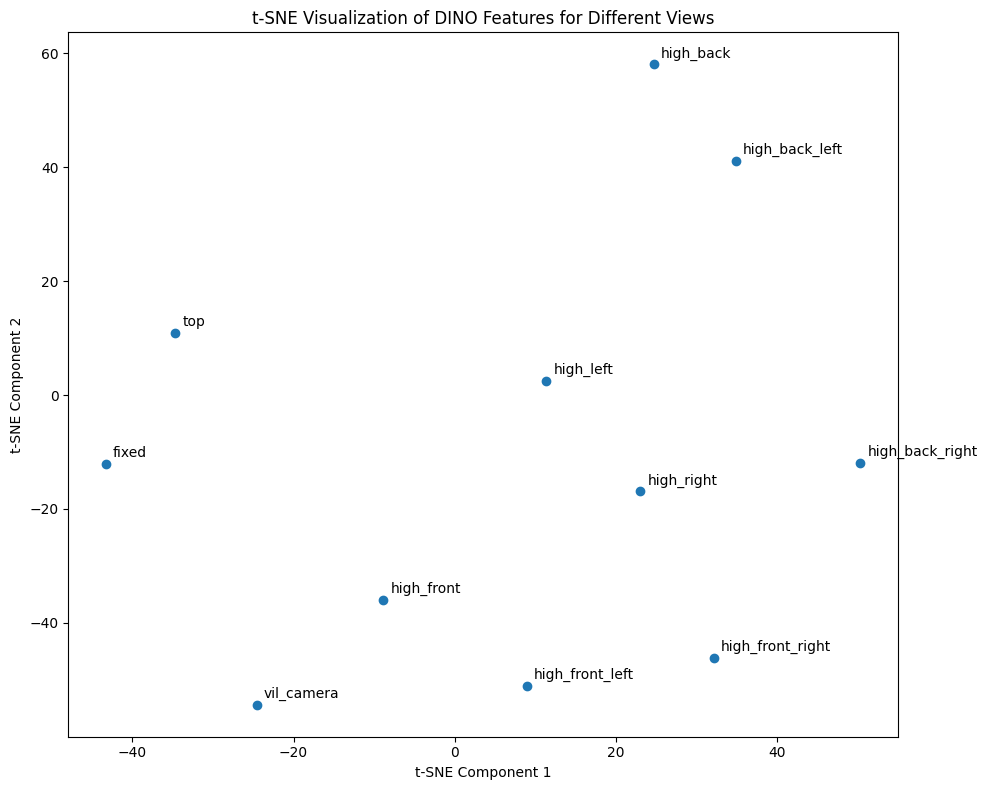

In [16]:
# Perform t-SNE on DINO features
from sklearn.manifold import TSNE
import numpy as np

# Convert DINO predictions to numpy for t-SNE
dino_features = dino_predictions.cpu().detach().numpy()

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Lower perplexity for small sample size
tsne_results = tsne.fit_transform(dino_features)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels for each point
view_names = ['high_right', 'high_left', 'high_front_right', 'fixed', 'top', 
              'high_back_right', 'high_back_left', 'high_front_left', 'high_back',
              'vil_camera', 'high_front']
for i, txt in enumerate(view_names):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

plt.title('t-SNE Visualization of DINO Features for Different Views')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()


In [23]:
vggt_tokens.shape, vggt_tokens[-1].shape, torch.cat(vggt_tokens, vggt_tokens[-1], dim).shape

NameError: name 'dim' is not defined

Flattened VGGT features shape: (11, 144)

Cluster 0 views: ['high_left', 'high_front_right', 'high_front_left', 'vil_camera', 'high_front']

Cluster 1 views: ['high_right', 'fixed', 'high_back_right', 'high_back_left', 'high_back']

Cluster 2 views: ['top']

Cluster 0 average distance to centroid: 0.54

Cluster 1 average distance to centroid: 0.49

Cluster 2 average distance to centroid: 0.00


/home/san/miniconda3/envs/dp3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


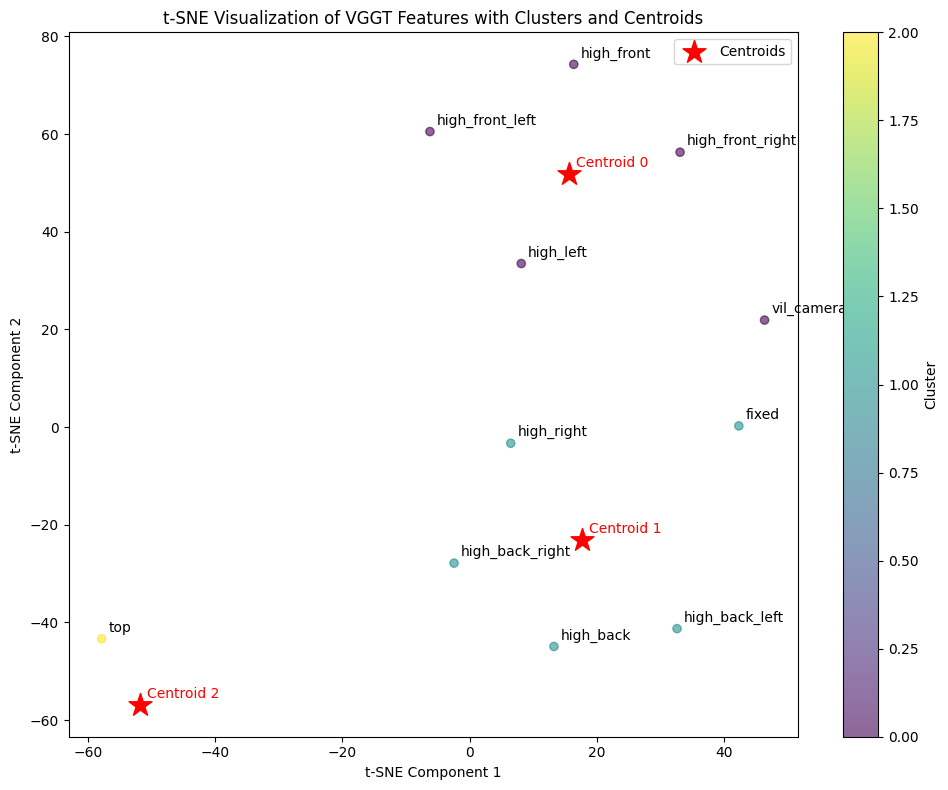

In [18]:
# Perform clustering across views using flattened features
from sklearn.cluster import KMeans

# Flatten VGGT features across patch dimension to get one vector per view
temp_vggt_tokens = torch.cat(vggt_tokens, vggt_tokens[-1]])

vggt_features = torch.mean(vggt_tokens, dim=-1).cpu().detach().numpy()
vggt_features = vggt_features.reshape(vggt_features.shape[1], -1)
print("Flattened VGGT features shape:", vggt_features.shape)

# Perform K-means clustering
n_clusters = 3  # Can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vggt_features)
centroids = kmeans.cluster_centers_

# Print which views belong to which clusters
view_names = ['high_right', 'high_left', 'high_front_right', 'fixed', 'top', 
              'high_back_right', 'high_back_left', 'high_front_left', 'high_back',
              'vil_camera', 'high_front']

for i in range(n_clusters):
    view_indices = np.where(cluster_labels == i)[0]
    cluster_views = [view_names[idx] for idx in view_indices]
    print(f"\nCluster {i} views: {cluster_views}")

# Calculate and print average distance to centroid for each cluster
from sklearn.metrics import pairwise_distances
for i in range(n_clusters):
    cluster_points = vggt_features[cluster_labels == i]
    centroid = centroids[i]
    distances = pairwise_distances(cluster_points, [centroid])
    avg_distance = np.mean(distances)
    print(f"\nCluster {i} average distance to centroid: {avg_distance:.2f}")

# Combine features and centroids for t-SNE
combined_data = np.vstack([vggt_features, centroids])

# Create labels for both features and centroids
feature_labels = cluster_labels
centroid_labels = np.array(range(n_clusters)) + n_clusters  # Distinct labels for centroids
combined_labels = np.concatenate([feature_labels, centroid_labels])

# Perform t-SNE on combined data
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(combined_data)

# Split results back into features and centroids
tsne_features = tsne_results[:len(vggt_features)]
tsne_centroids = tsne_results[len(vggt_features):]

plt.figure(figsize=(10, 8))
# Plot feature points
scatter_features = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], 
                             c=cluster_labels, cmap='viridis', alpha=0.6)

# Plot centroids
scatter_centroids = plt.scatter(tsne_centroids[:, 0], tsne_centroids[:, 1], 
                              c='red', marker='*', s=300, label='Centroids')

# Add labels for feature points
for i, txt in enumerate(view_names):
    plt.annotate(txt, (tsne_features[i, 0], tsne_features[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

# Add labels for centroids
for i in range(n_clusters):
    plt.annotate(f'Centroid {i}', (tsne_centroids[i, 0], tsne_centroids[i, 1]),
                xytext=(5, 5), textcoords='offset points', color='red')

plt.title('t-SNE Visualization of VGGT Features with Clusters and Centroids')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter_features, label='Cluster')
plt.legend()
plt.tight_layout()
plt.show()



In [17]:
vggt_features.shape, torch.mean(vggt_tokens, dim=-1).shape


NameError: name 'vggt_features' is not defined

(11, 144)


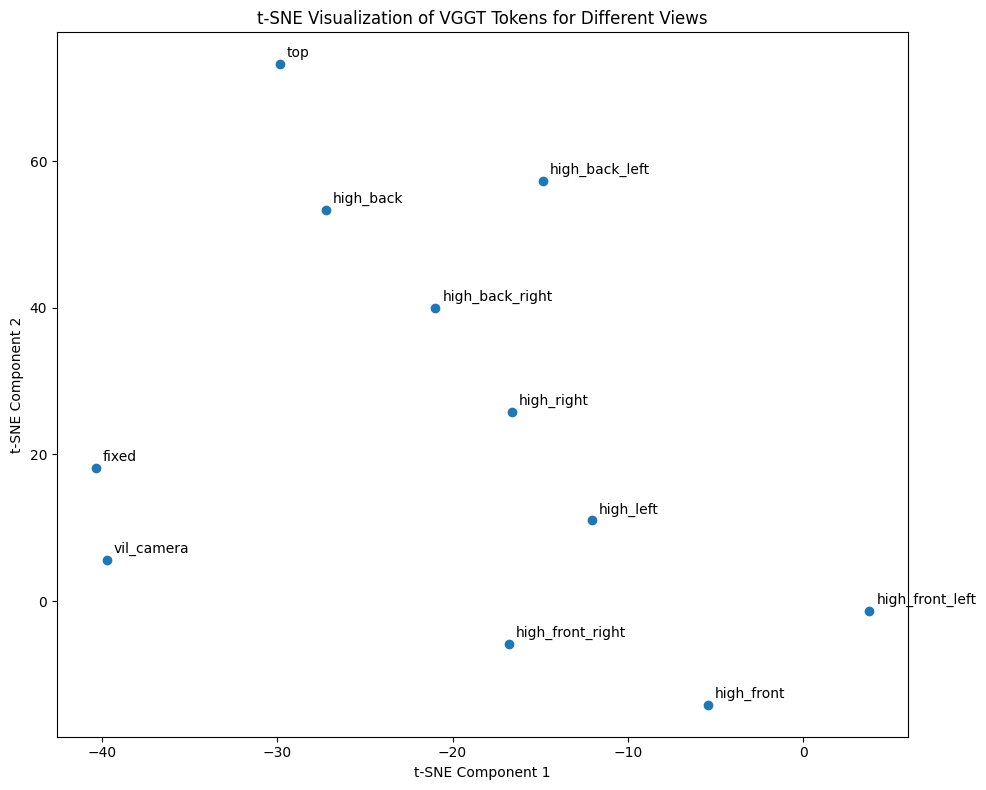

In [ ]:
# Perform t-SNE on VGGT tokens
from sklearn.manifold import TSNE
import numpy as np


# Convert VGGT tokens to numpy for t-SNE
vggt_features = torch.mean(vggt_tokens, dim=-1).cpu().detach().numpy()
vggt_features = vggt_features.reshape(vggt_features.shape[1], -1)
print(vggt_features.shape)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Lower perplexity for small sample size
tsne_results = tsne.fit_transform(vggt_features)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels for each point
view_names = ['high_right', 'high_left', 'high_front_right', 'fixed', 'top', 
              'high_back_right', 'high_back_left', 'high_front_left', 'high_back',
              'vil_camera', 'high_front']
for i, txt in enumerate(view_names):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

plt.title('t-SNE Visualization of VGGT Tokens for Different Views')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()


(11, 2048)


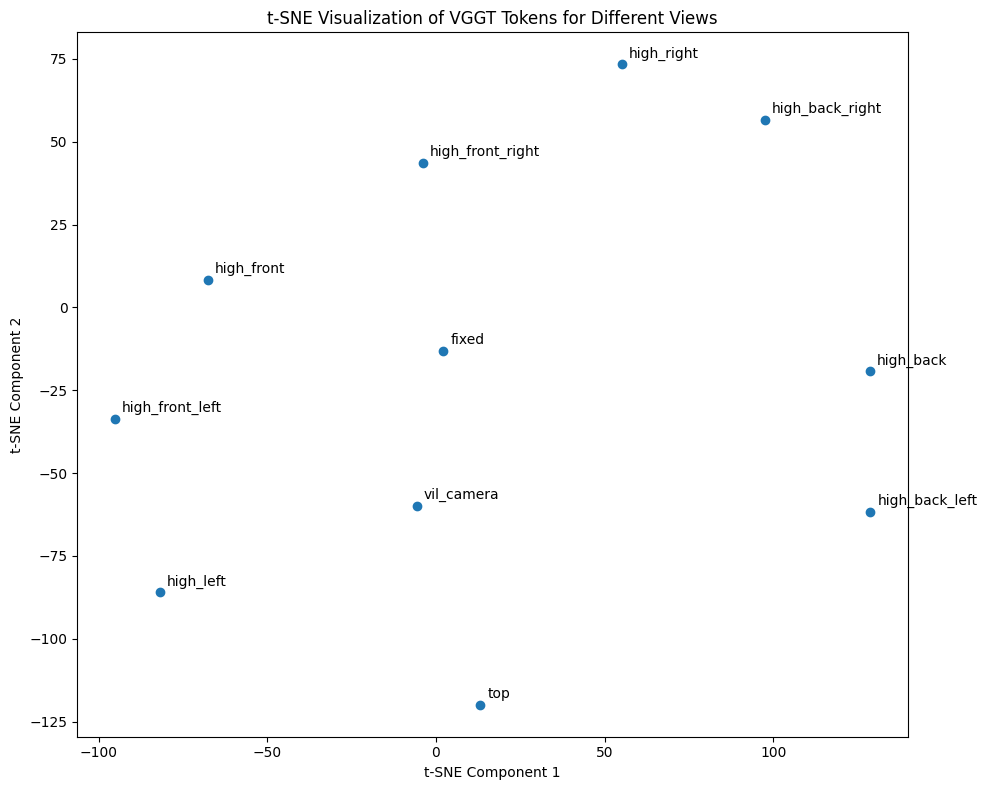

In [12]:
# Perform t-SNE on VGGT tokens
from sklearn.manifold import TSNE
import numpy as np


# Convert VGGT tokens to numpy for t-SNE : mean of patches 
vggt_features = torch.mean(vggt_tokens, dim=-2).cpu().detach().numpy()
vggt_features = vggt_features.reshape(vggt_features.shape[1], -1)
print(vggt_features.shape)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Lower perplexity for small sample size
tsne_results = tsne.fit_transform(vggt_features)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels for each point
view_names = ['high_right', 'high_left', 'high_front_right', 'fixed', 'top', 
              'high_back_right', 'high_back_left', 'high_front_left', 'high_back',
              'vil_camera', 'high_front']
for i, txt in enumerate(view_names):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

plt.title('t-SNE Visualization of VGGT Tokens for Different Views')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()


In [17]:
dino_features.shape, vggt_features.shape

((11, 384), (11, 2048))

In [24]:
import torch

# Function to compute the Gram matrix
def compute_gram(X):
    return X @ X.T

# Function to compute Linear CKA using the Gram matrices
def linear_cka_gram(X, Y):
    X = X - X.mean(0, keepdim=True)  # Center X
    Y = Y - Y.mean(0, keepdim=True)  # Center Y

    # Compute Gram matrices for both feature sets
    X_gram = compute_gram(X)
    Y_gram = compute_gram(Y)

    # Compute CKA
    dot_product_similarity = (X_gram * Y_gram).sum()
    normalization_x = (X_gram * X_gram).sum()
    normalization_y = (Y_gram * Y_gram).sum()

    return dot_product_similarity / (normalization_x.sqrt() * normalization_y.sqrt())

# Convert your numpy features to torch tensors
dino_tensor = torch.from_numpy(dino_features)
vggt_tensor = torch.from_numpy(vggt_features)

# Compute CKA
cka_value = linear_cka_gram(dino_tensor, vggt_tensor)
print(f"Linear CKA between DINO and VGGT: {cka_value.item():.4f}")

Linear CKA between DINO and VGGT: 0.7228


In [20]:
type(dino_features)

numpy.ndarray

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ======= Assume you have these already =======
# dino_embeds: (11, 384)
# vggt_embeds: (11, 2048)

# 1. Convert to numpy
dino_np = torch.from_numpy(dino_features).cpu().numpy()
vggt_np = torch.from_numpy(vggt_features).cpu().numpy()

print(dino_np.shape, vggt_np.shape)
# 2. First, reduce VGGT from 2048 -> 384 with PCA (optional)
pca_vggt = PCA(n_components=384)
vggt_pca = pca_vggt.fit_transform(vggt_np)

# 3. Stack DINO and VGGT features together (both 384d now)
features_combined = np.vstack([dino_np, vggt_pca])

# 4. t-SNE into 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42, init="pca", learning_rate='auto')
features_2d = tsne.fit_transform(features_combined)

# 5. Split back into DINO and VGGT
features_2d_dino = features_2d[:11]
features_2d_vggt = features_2d[11:]

# 6. Plot
plt.figure(figsize=(8, 6))
plt.scatter(features_2d_dino[:,0], features_2d_dino[:,1], c='blue', label='DINO', s=100, marker='o')
plt.scatter(features_2d_vggt[:,0], features_2d_vggt[:,1], c='red', label='VGGT', s=100, marker='^')

for i in range(11):
    plt.plot([features_2d_dino[i,0], features_2d_vggt[i,0]], 
             [features_2d_dino[i,1], features_2d_vggt[i,1]], 
             c='gray', linestyle='--', alpha=0.5)

plt.legend()
plt.title('t-SNE Comparison: DINO vs VGGT')
plt.grid(True)
plt.show()

(11, 384) (11, 2048)


ValueError: n_components=384 must be between 0 and min(n_samples, n_features)=11 with svd_solver='full'